## Decision Trees
In this type of machine learning algorithm, we are using information theory to determine the best possible way how to split given data.<br>
<br>
- `Classification tree` (Decision tree classifies things into the categories )
- `Regression tree` (Decision tree predicts numeric values)

<br>
Imagine that we have a set of points $\mathbb{M} = \{(x_1, y_1), (x_2, y_2), \dots, (x_n, y_n)\}$.

<div style="display: flex; justify-content: center;">
<img src="./images/DT1.png" alt="Flower" style="width:500px;"/></div>

Choose a random two points $(x_1, y_1) and (x_2, y_2)$ from them and draw a lines $l_1, l_2$ through them.

<div style="display: flex; justify-content: center;">
<img src="./images/DT2.png" alt="Flower" style="width:500px;"/></div>

As first, find the two subsets $\mathbb{M}_1, \mathbb{M}_2$ created by line $l_1$, where

$$ \mathbb{M}_1 = \{ (x,y) \in \mathbb{M} | y > y_1 \} \qquad \wedge \qquad \mathbb{M}_2 = \{ (x,y) \in \mathbb{M} | y \leq y_1 \} $$

and find the `Information Gain - IG` of $\mathbb{M}_1$ and $\mathbb{M}_2$.

$$ IG = E_{sup} - \sum_{i=1} w_i E_i, $$
where $E_{sup}$ is superset of a given subset $\mathbb{M}_i$ and $w_i$ is telling us how big part of the whole superset $\mathbb{M}$ belongs to the subset $\mathbb{M_i}$ ($w_i = \frac{\#\mathbb{M_i}}{\#\mathbb{M}}$).

$$ E = -\sum_{i=1}^{} p_i\cdot\log{p_i} \qquad \wedge \qquad p_i = \frac{n_i}{n},$$
where $n_i$ denotes number of points with same color.

<div style="display: flex; justify-content: center;">
<img src="./images/DT3.png" alt="Flower" style="width:500px;"/></div>

Now do exactly the same with line $l_2$.

<div style="display: flex; justify-content: center;">
<img src="./images/DT4.png" alt="Flower" style="width:500px;"/></div>
<div style="display: flex; justify-content: center;">
<img src="./images/DT5.png" alt="Flower" style="width:500px;"/></div>
<div style="display: flex; justify-content: center;">
<img src="./images/DT6.png" alt="Flower" style="width:500px;"/></div>

We can clearly see by comparison $IG_1$ and $IG_2$ that the information gained by dividing the data using line $l_1$ is a lot bigger. In this manner we are able to find the best choice of dividing line so the value of $IG$ will be maximized.<br>
Finally do the same as we have done with $\mathbb{M}$, with all its subsets recursively.

In [2]:
import matplotlib.pyplot as plt
import seaborn as sn

from sklearn.metrics import confusion_matrix

In [13]:
import numpy as np
from collections import Counter

class Node:
    def __init__(self, feature=None, threshold=None, left=None, right=None,*,value=None):
        self.feature = feature
        self.threshold = threshold
        self.left = left
        self.right = right
        self.value = value
        
    def is_leaf_node(self):
        return self.value is not None


class DecisionTree:
    def __init__(self, min_samples_split=2, max_depth=100, n_features=None):
        self.min_samples_split=min_samples_split
        self.max_depth=max_depth
        self.n_features=n_features
        self.root=None

    def fit(self, X, y):
        self.n_features = X.shape[1] if not self.n_features else min(X.shape[1],self.n_features)
        self.root = self._grow_tree(X, y)

    def _grow_tree(self, X, y, depth=0):
        n_samples, n_feats = X.shape
        n_labels = len(np.unique(y))

        # check the stopping criteria
        if (depth>=self.max_depth or n_labels==1 or n_samples<self.min_samples_split):
            leaf_value = self._most_common_label(y)
            return Node(value=leaf_value)

        feat_idxs = np.random.choice(n_feats, self.n_features, replace=False)

        # find the best split
        best_feature, best_thresh = self._best_split(X, y, feat_idxs)

        # create child nodes
        left_idxs, right_idxs = self._split(X[:, best_feature], best_thresh)
        left = self._grow_tree(X[left_idxs, :], y[left_idxs], depth+1)
        right = self._grow_tree(X[right_idxs, :], y[right_idxs], depth+1)
        return Node(best_feature, best_thresh, left, right)


    def _best_split(self, X, y, feat_idxs):
        best_gain = -1
        split_idx, split_threshold = None, None

        for feat_idx in feat_idxs:
            X_column = X[:, feat_idx]
            thresholds = np.unique(X_column)

            for thr in thresholds:
                # calculate the information gain
                gain = self._information_gain(y, X_column, thr)

                if gain > best_gain:
                    best_gain = gain
                    split_idx = feat_idx
                    split_threshold = thr

        return split_idx, split_threshold


    def _information_gain(self, y, X_column, threshold):
        # parent entropy
        parent_entropy = self._entropy(y)

        # create children
        left_idxs, right_idxs = self._split(X_column, threshold)

        if len(left_idxs) == 0 or len(right_idxs) == 0:
            return 0
        
        # calculate the weighted avg. entropy of children
        n = len(y)
        n_l, n_r = len(left_idxs), len(right_idxs)
        e_l, e_r = self._entropy(y[left_idxs]), self._entropy(y[right_idxs])
        child_entropy = (n_l/n) * e_l + (n_r/n) * e_r

        # calculate the IG
        information_gain = parent_entropy - child_entropy
        return information_gain

    def _split(self, X_column, split_thresh):
        left_idxs = np.argwhere(X_column <= split_thresh).flatten()
        right_idxs = np.argwhere(X_column > split_thresh).flatten()
        return left_idxs, right_idxs

    def _entropy(self, y):
        hist = np.bincount(y)
        ps = hist / len(y)
        return -np.sum([p * np.log(p) for p in ps if p>0])


    def _most_common_label(self, y):
        counter = Counter(y)
        value = counter.most_common(1)[0][0]
        return value

    def predict(self, X):
        return np.array([self._traverse_tree(x, self.root) for x in X])

    def _traverse_tree(self, x, node):
        if node.is_leaf_node():
            return node.value

        if x[node.feature] <= node.threshold:
            return self._traverse_tree(x, node.left)
        return self._traverse_tree(x, node.right)

## Let's try it out

In [14]:
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split

data = load_breast_cancer()
X, y = data.data, data.target

x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1234)

clf = DecisionTree()
clf.fit(x_train, y_train)
predictions = clf.predict(x_test)

### Find the confusion matrix of our model

Text(69.0, 0.5, 'Truth')

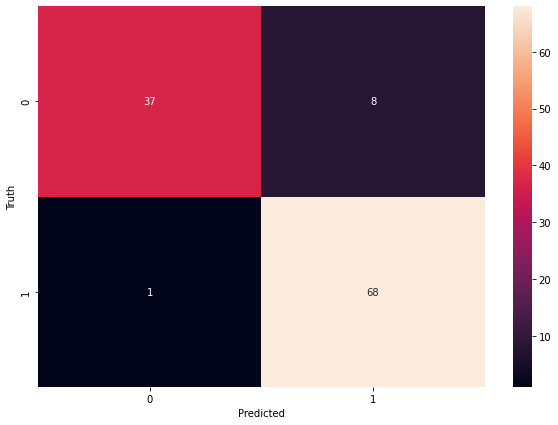

In [15]:
cm = confusion_matrix(y_test, predictions)

# Make it a little bit bigger
plt.figure(figsize=(10,7))

# Plot by seaborn
sn.heatmap(cm, annot=True)

# Add axis labels
plt.xlabel("Predicted")
plt.ylabel("Truth")